<a href="https://colab.research.google.com/github/marcomedugno/marcomedugno/blob/main/Classifying_Images_with_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Dress Types - PyTorch
Design and train a basic neural network on the FashionMNIST dataset

## Marco Medugno


In [ ]:
# import the necessary libraries
import math
import torch
from torch.utils.data import DataLoader #Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor
from torch import nn, optim
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout

In [ ]:
# displays output inline
%matplotlib inline

In [ ]:
# train model on a hardware accelerator like the GPU if it is available, otherwise continue to use the CPU
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Data Preprocessing

In [ ]:
# use FashionMNIST dataset published by Zalando Research
data_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor()) # =Compose([ToTensor()])
data_test = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor()) # =Compose([ToTensor()])
batch = 85
load_train = DataLoader(data_train, batch_size=batch, shuffle=True)
load_test = DataLoader(data_test, batch_size=batch, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# 60,000 training images, each image is a grayscale image with size 28x28 pixels
# 10,000 testing images, each image is a grayscale image with size 28x28 pixels
data_train.data.shape, data_train.targets.shape, data_train.targets.bincount(), data_test.data.shape, data_test.targets.shape, data_test.targets.bincount()

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [ ]:
# ten categories from 0 to 9
data_train.classes, data_test.classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

In [ ]:
# scale the values between 0 and 1 for both training and testing sets
data_train.data = data_train.data / 255.0
data_test.data = data_test.data / 255.0

# Training Set

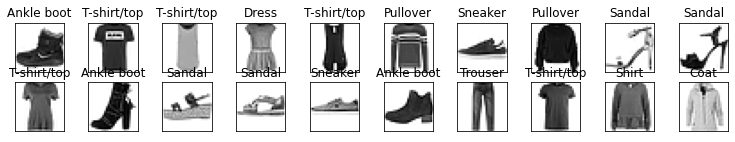

In [ ]:
# plot a grid of images with titles of correct names and labels of predicted names
def plot(images, labels, predictions=None):
  # create a grid with 10 columns
  n_cols = min(10, len(images))
  n_rows = math.ceil(len(images) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, n_rows))
  if predictions is None:
    predictions = [None] * len(labels)
  for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
    ax = axes.flat[index]
    ax.imshow(x, cmap=plt.cm.binary)
    ax.set_title(data_train.classes[y_true])
    if y_pred is not None:
      ax.set_xlabel(data_train.classes[y_pred])
    ax.set_xticks([])
    ax.set_yticks([])
# plot first 20 images
plot(data_train.data[:20], data_train.targets[:20])

# Model in PyTorch

In [ ]:
# create a sequential model of one hidden layer
input_size = 28 * 28
hidden_size = 128
output_size = 10
model = nn.Sequential(
  nn.Linear(input_size, hidden_size), # apply linear transformation to hidden = input A^T + b
  nn.ReLU(), # apply the rectified linear unit function element-wise
  nn.Linear(hidden_size, output_size), # apply linear transformation to output = hidden A^T + b
  nn.Softmax(dim=1)) # apply the dimensional output Tensor within the range [0,1] and sum to 1
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


In [ ]:
# train the model
torch.manual_seed(20742)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
epochs = 40
for epoch in range(epochs):
  running_loss = 0
  for images, labels in load_train:
    train = images.view(images.shape[0], -1) # flatten image into a 784 vector
    outputs = model(train)
    loss = error(outputs, labels)
    optimizer.zero_grad() # training pass
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      train = images.view(images.shape[0], -1) # flatten image into a 784 vector
      outputs = model(train)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/40 - loss: 0.022156233934561412 - accuracy: 0.6565666794776917
Epoch 2/40 - loss: 0.021215374128023785 - accuracy: 0.6781166791915894
Epoch 3/40 - loss: 0.021045095147689184 - accuracy: 0.6722000241279602
Epoch 4/40 - loss: 0.020961940421660743 - accuracy: 0.6906166672706604
Epoch 5/40 - loss: 0.020882441620031993 - accuracy: 0.6930166482925415
Epoch 6/40 - loss: 0.020818373948335647 - accuracy: 0.6962000131607056
Epoch 7/40 - loss: 0.020773603133360546 - accuracy: 0.7055500149726868
Epoch 8/40 - loss: 0.02073055657148361 - accuracy: 0.7100333571434021
Epoch 9/40 - loss: 0.02067356443206469 - accuracy: 0.71506667137146
Epoch 10/40 - loss: 0.02063447891076406 - accuracy: 0.7122166752815247
Epoch 11/40 - loss: 0.02061901079018911 - accuracy: 0.7177333235740662
Epoch 12/40 - loss: 0.020574819763501485 - accuracy: 0.7217666506767273
Epoch 13/40 - loss: 0.02054117743174235 - accuracy: 0.7202333211898804
Epoch 14/40 - loss: 0.020503079324960708 - accuracy: 0.720716655254364
Epoch 15/

In [ ]:
# save the model
torch.save(model, './Act6_Last_First_model.pt') 

# Testing Set

In [ ]:
count = 0
correct = 0
for images, labels in load_test:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 10000 images - accuracy: 0.6922000050544739


In [ ]:
count = 0
correct = 0
for image, label in data_test:
  test = image.view(1, 784) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    pred = probs.argmax(1)
  if (pred == label):
    correct += 1
  count += 1
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 10000 images - accuracy: 0.6922


# Application

In [ ]:
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(data_test) - 1, description='Image index', layout=Layout(width='100%'))
@interact(index=img_idx_slider)
def visualize_prediction(index=0):
  image, label = data_test[index]
  test = image.view(1, 28 * 28)
  with torch.no_grad():
    probs = model(test)
  pred = probs.argmax(1).item()
  fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  ax1.imshow(data_test.data[index], cmap=plt.cm.binary)
  ax1.set_title(f'Label: {data_test.classes[data_test.targets[index]]}')
  ax1.set_xlabel(f'Predict: {data_test.classes[pred]}')
  ax1.set_ylabel('Pixel location index')
  ax1.set_xticks(range(28))
  ax1.set_yticks(range(28))
  ax1.xaxis.tick_top()
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.bar(x=data_test.classes, height=probs[0]*100)
  ax2.set_xlabel('Prediction')
  ax2.set_ylabel('Probability (%)')
  ax2.set_ylim(0, 100)
  ax2.tick_params(axis='x', labelrotation=90)

interactive(children=(IntSlider(value=0, description='Image index', layout=Layout(width='100%'), max=9999), Ou…